<a href="https://colab.research.google.com/github/meetAmarAtGithub/Reva_NLPandText-Analytics/blob/main/ai03_TRIM02_Module06_NLP%26Text_Analytics_Assignment3_GoodRead_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/My Drive/Colab Notebooks/Reva/5_NLP_TextAnalytics"

/content/gdrive/My Drive/Colab Notebooks/Reva/5_NLP_TextAnalytics


In [3]:
# Transformers installation
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 28.9 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 6.6 MB 62.6 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import numpy as np
import pandas as pd
import string
!pip install text_hammer
import text_hammer as th
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict
#%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from transformers import AutoTokenizer,TFBertModel

max_len = 36

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import Word 
from wordcloud import WordCloud

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 26.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# <font color="green">**Data Pre-processing**</font>

In [5]:
goodread_file = '/content/gdrive/My Drive/Colab Notebooks/Reva/5_NLP_TextAnalytics/goodreads_test.csv'

In [6]:
import chardet
with open(goodread_file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 1.0, 'encoding': 'ascii', 'language': ''}

In [7]:
df = pd.read_csv(goodread_file,encoding='ISO-8859-1')
df.tail(10)

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
478023,35cef391b171b4fca45771e508028212,15820748,4d100043d665a2eb8eb67d9a91bac212,So... \n My reaction when I realized not only ...,Fri Dec 07 13:56:49 -0800 2012,Fri Dec 13 07:33:27 -0800 2013,Tue Mar 05 00:00:00 -0800 2013,NaN,50,0
478024,35cef391b171b4fca45771e508028212,9897164,2463ab4aa505d364a7ff10a91e6594d0,Just read a preview of the first chapter and H...,Thu Nov 08 10:49:50 -0800 2012,Sun Apr 07 17:14:48 -0700 2013,Tue Apr 09 00:00:00 -0700 2013,NaN,1,0
478025,35cef391b171b4fca45771e508028212,13519844,b44e3c44b2dcf2330feee9c94a720635,The Significance Series is one I've truly enjo...,Tue Sep 11 20:11:27 -0700 2012,Thu Jan 24 15:20:26 -0800 2013,Tue Dec 18 00:00:00 -0800 2012,NaN,0,0
478026,35cef391b171b4fca45771e508028212,10616322,cf59c2b85ec7bfcdb94cf186238e1097,"I loved this series, but was seriously let dow...",Tue Sep 11 20:10:23 -0700 2012,Fri Dec 27 15:33:31 -0800 2013,Tue Oct 22 00:00:00 -0700 2013,NaN,0,0
478027,35cef391b171b4fca45771e508028212,13362536,81ce7119166bb21c081721188c3a97bc,Implants are everywhere! \n Oh my gosh...this ...,Wed Sep 05 10:37:19 -0700 2012,Thu Feb 21 21:38:58 -0800 2013,Tue Dec 11 00:00:00 -0800 2012,NaN,0,0
478028,35cef391b171b4fca45771e508028212,15745950,0e1db3d4b04256f9660f5d276ddf1314,Can't wait for Travis' POV \n Travis Before Ab...,Sun Aug 05 10:26:12 -0700 2012,Tue Apr 16 17:24:00 -0700 2013,Tue Apr 16 00:00:00 -0700 2013,NaN,0,0
478029,35cef391b171b4fca45771e508028212,10861195,0b7f352e58caf0fd1f961e98ef04e89c,Had this on my to-read shelf forever. Will upd...,Tue Jul 10 23:31:00 -0700 2012,Fri Dec 28 20:05:51 -0800 2012,NaN,NaN,0,0
478030,35cef391b171b4fca45771e508028212,6131164,9b19eff33ddb14e9e68fca2e90379e46,The last book left me wanting for more. I need...,Tue Jul 10 19:45:17 -0700 2012,Mon Mar 25 18:41:51 -0700 2013,Tue Mar 19 00:00:00 -0700 2013,NaN,0,0
478031,35cef391b171b4fca45771e508028212,10025305,8be463fed78f0da63e964706f710332b,Things are heating up in the second novel of I...,Thu Jul 05 19:19:30 -0700 2012,Thu Jan 24 16:24:54 -0800 2013,Mon Jan 14 00:00:00 -0800 2013,NaN,0,0
478032,35cef391b171b4fca45771e508028212,6482837,62ed1263c7d216986cc419cd4e8a408b,"Before I even start this review, I must say th...",Mon Jun 04 18:06:26 -0700 2012,Sat Dec 29 17:47:56 -0800 2012,NaN,NaN,0,0


In [8]:
goodread = df[['review_text','n_votes']]
goodread.head(5)

,review_text,n_votes
0,** spoiler alert ** \n This is definitely one ...,1
1,"** spoiler alert ** \n ""You are what you drink...",1
2,Roar is one of my favorite characters in Under...,0
3,** spoiler alert ** \n If you feel like travel...,0
4,3.5 stars \n I read and enjoyed the first two ...,0


In [9]:
goodread.rename(columns = {'n_votes':'target', 'review_text':'text'}, inplace = True)
goodread.head(2)

,text,target
0,** spoiler alert ** \n This is definitely one ...,1
1,"** spoiler alert ** \n ""You are what you drink...",1


In [10]:
#just taking 8000 records overall to build my model
goodread = goodread.iloc[:8000]

In [11]:
goodread.shape

(8000, 2)

### <font color="blue">**Remove Stopwords and Delimeter**</font>

In [12]:
def text_process(mess):
    nopunc =[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])


goodread['text'] = goodread['text'].apply(text_process)
goodread.head(3)

,text,target
0,spoiler alert definitely one favorites among f...,1
1,spoiler alert drink Im huge fan coffee dont bu...,1
2,Roar one favorite characters Never Sky Im happ...,0


### <font color="blue">**Lemmatization**</font><br/>In simpler terms, it is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors. For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care’, whereas, stemming would cutoff the ‘ing’ part and convert it to car. Lemmatization can be implemented in python by using Wordnet Lemmatizer, Spacy Lemmatizer, TextBlob, Stanford CoreNLP

In [14]:
lemmatizer = WordNetLemmatizer()

print('With out Lammetization - ', goodread['text'][2])

goodread['text'] = goodread['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print('With Lemmatization -     ',  goodread['text'][2])

goodread.head(5)

With out Lammetization -  Roar one favorite character Never Sky Im happy read story Roar usually happy going kind guy book see serious side novella left wanting felt bad Liv RoarI hate Vale could sell sister Anyway hope Roar find Liv next book
With Lemmatization -      Roar one favorite character Never Sky Im happy read story Roar usually happy going kind guy book see serious side novella left wanting felt bad Liv RoarI hate Vale could sell sister Anyway hope Roar find Liv next book


,text,target
0,spoiler alert definitely one favorite among fo...,1
1,spoiler alert drink Im huge fan coffee dont bu...,1
2,Roar one favorite character Never Sky Im happy...,0
3,spoiler alert feel like travelling Europe dont...,0
4,35 star read enjoyed first two novel series sa...,0


### <font color="blue"> **Remove links from the dataset.** <br> **Remove special characters or symbols from the dataset.** <br> **Remove numbers or alphanumerical characters from the dataset.**</font>

In [ ]:
goodread['text'] = goodread['text'].str.replace(r'([\w\.-]+)@([\w\.-]+)',' ') #remove email addresses
goodread['text'] = goodread['text'].str.replace(r'[^\w\s]',' ') #remove punctuations and special chareters from dataset
goodread['text'] = goodread['text'].str.replace(r'(https|http)?:\/\/(\w|\.|\_|\/|\?|\=|\&|\%)*\b', ' ') # Remove links from the dataset.
goodread['text'] = goodread['text'].str.replace(r'[^\w]', ' ') #Remove not alphanumeric symbols white spaces

goodread.tail(4)

,text,target
7996,3 5 The plotting adventure and prose in th...,0
7997,That ending though,1
7998,3 5 stars I really enjoyed the creative readi...,0
7999,If you ve never read the first book in the Ill...,1


## <font color="blue">**WORD CLOUD**</font>:

<Figure size 864x720 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

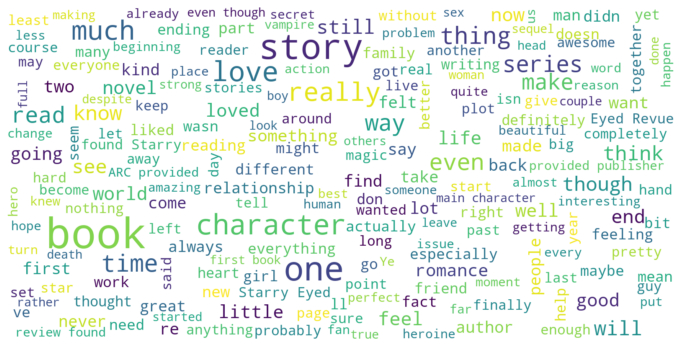

In [ ]:
#Good read wordcloud if votes is more than 5
spam_message = goodread[goodread.target > 5]
spam_string = []
for t in spam_message.text:
    spam_string.append(t)
disaster_string = pd.Series(spam_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<Figure size 864x720 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

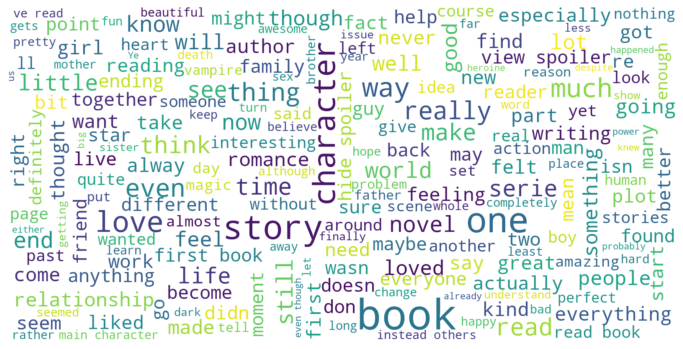

In [ ]:
#Good read wordcloud if votes is less than 5
spam_message = goodread[goodread.target <= 5]
spam_string = []
for t in spam_message.text:
    spam_string.append(t)
disaster_string = pd.Series(spam_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## <font color="blue">**DATA VISUALIZATION**</font>:

In [ ]:
# word_count
goodread['word_count'] = goodread['text'].apply(lambda x: len(str(x).split()))
goodread['word_count'] = goodread['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
goodread['unique_word_count'] = goodread['text'].apply(lambda x: len(set(str(x).split())))
goodread['unique_word_count'] = goodread['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
goodread['stop_word_count'] = goodread['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
goodread['stop_word_count'] = goodread['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
goodread['url_count'] = goodread['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
goodread['url_count'] = goodread['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
goodread['mean_word_length'] = goodread['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
goodread['mean_word_length'] = goodread['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
goodread['char_count'] = goodread['text'].apply(lambda x: len(str(x)))
goodread['char_count'] = goodread['text'].apply(lambda x: len(str(x)))

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'word_count Target Distribution in Training Set')

Text(0.5, 1.0, 'word_count Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'unique_word_count Target Distribution in Training Set')

Text(0.5, 1.0, 'unique_word_count Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'stop_word_count Target Distribution in Training Set')

Text(0.5, 1.0, 'stop_word_count Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'url_count Target Distribution in Training Set')

Text(0.5, 1.0, 'url_count Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'mean_word_length Target Distribution in Training Set')

Text(0.5, 1.0, 'mean_word_length Training & Test Set Distribution')

Text(0.5, 0, '')

Text(0.5, 0, '')

Text(0.5, 1.0, 'char_count Target Distribution in Training Set')

Text(0.5, 1.0, 'char_count Training & Test Set Distribution')

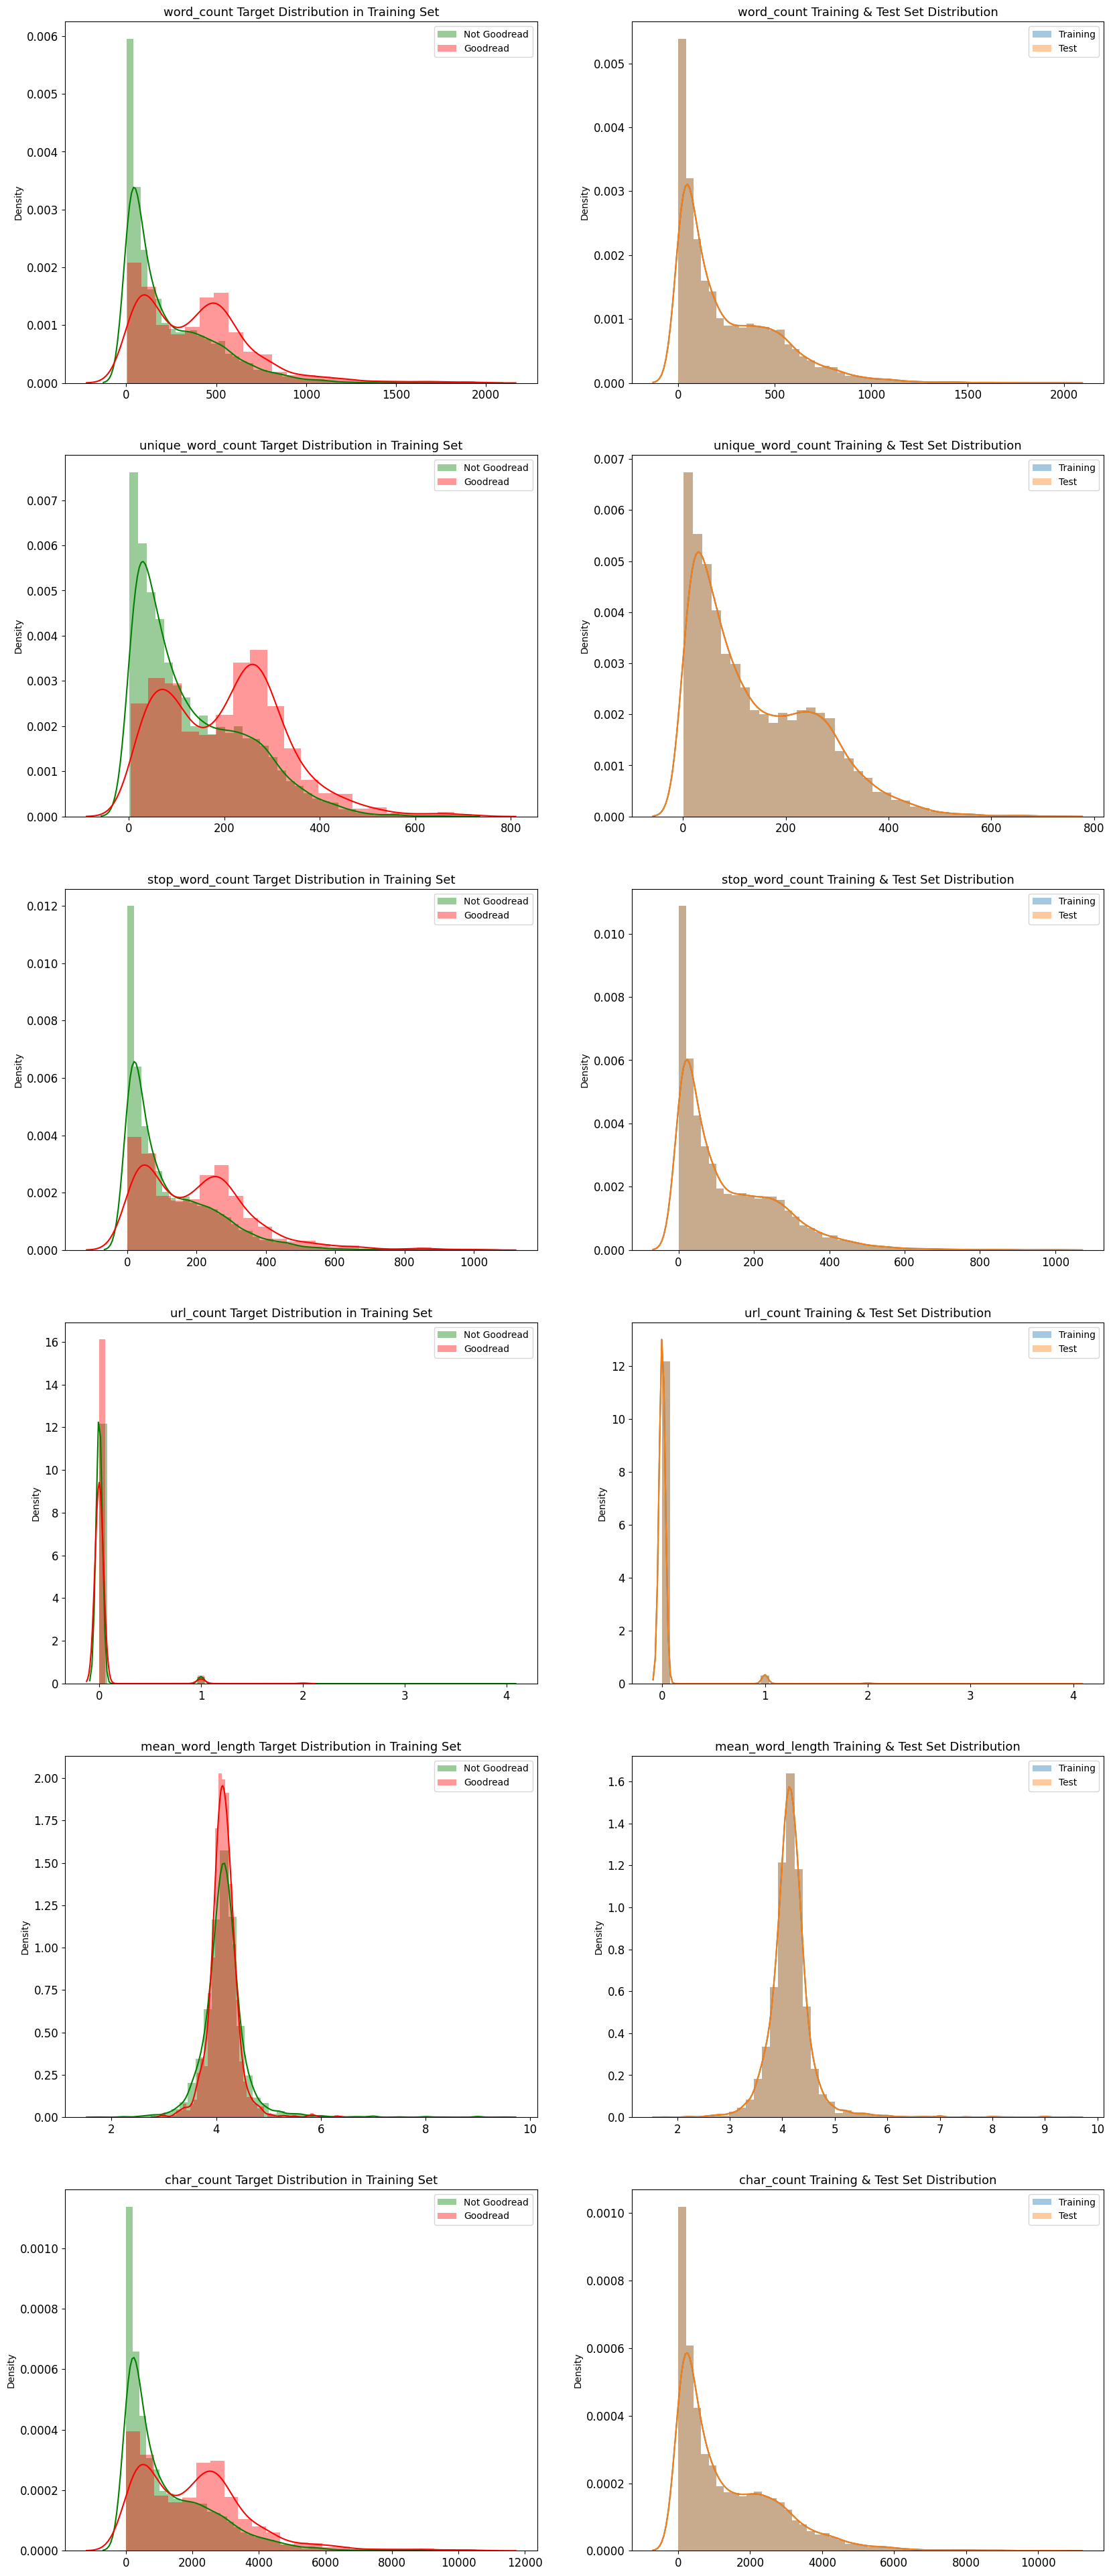

In [ ]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
Books = goodread['target'] > 5

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(goodread.loc[~Books][feature], label='Not Goodread', ax=axes[i][0], color='green')
    sns.distplot(goodread.loc[Books][feature], label='Goodread', ax=axes[i][0], color='red')

    sns.distplot(goodread[feature], label='Training', ax=axes[i][1])
    sns.distplot(goodread[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

#<font color='brown'><b>Model creation and prediction</b></font><br>
## BERT - Bidirectional Encoder Representations from Transformers

BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

The best part about BERT is that we can use the BERT models to extract high quality language features from our text data.<br>
## <font color="blue">Train-Test Split and perform the classification task using the Naive Bayes classification model. <br> </font>

In [ ]:
train_data = goodread.iloc[:5000]

len(train_data)

5000

In [ ]:
test_data  = goodread.iloc[5001:len(goodread)]

len(test_data)

2999

## LOADING THE BERT MODEL:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_train['input_ids'].shape
print()
x_train['attention_mask'].shape

TensorShape([5000, 36])

TensorShape([5000, 36])

In [ ]:
y_train = train_data.target.values
y_train.shape

(5000,)

In [ ]:
train_data.target.value_counts()

0      2732
1       849
2       368
3       226
4       176
5       111
6        90
7        85
8        52
9        44
12       33
10       33
11       31
13       24
14       18
17       12
21       11
16       11
15       11
19        9
22        7
25        6
33        5
18        5
29        5
31        4
26        4
20        4
28        3
34        3
23        3
27        3
30        3
24        2
37        2
42        2
41        2
73        2
40        1
45        1
35        1
186       1
54        1
39        1
76        1
226       1
36        1
Name: target, dtype: int64

## BUILDING THE MODEL ARCHITECTURE:

In [ ]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

# for training bert our lr must be so small

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                          

In [ ]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

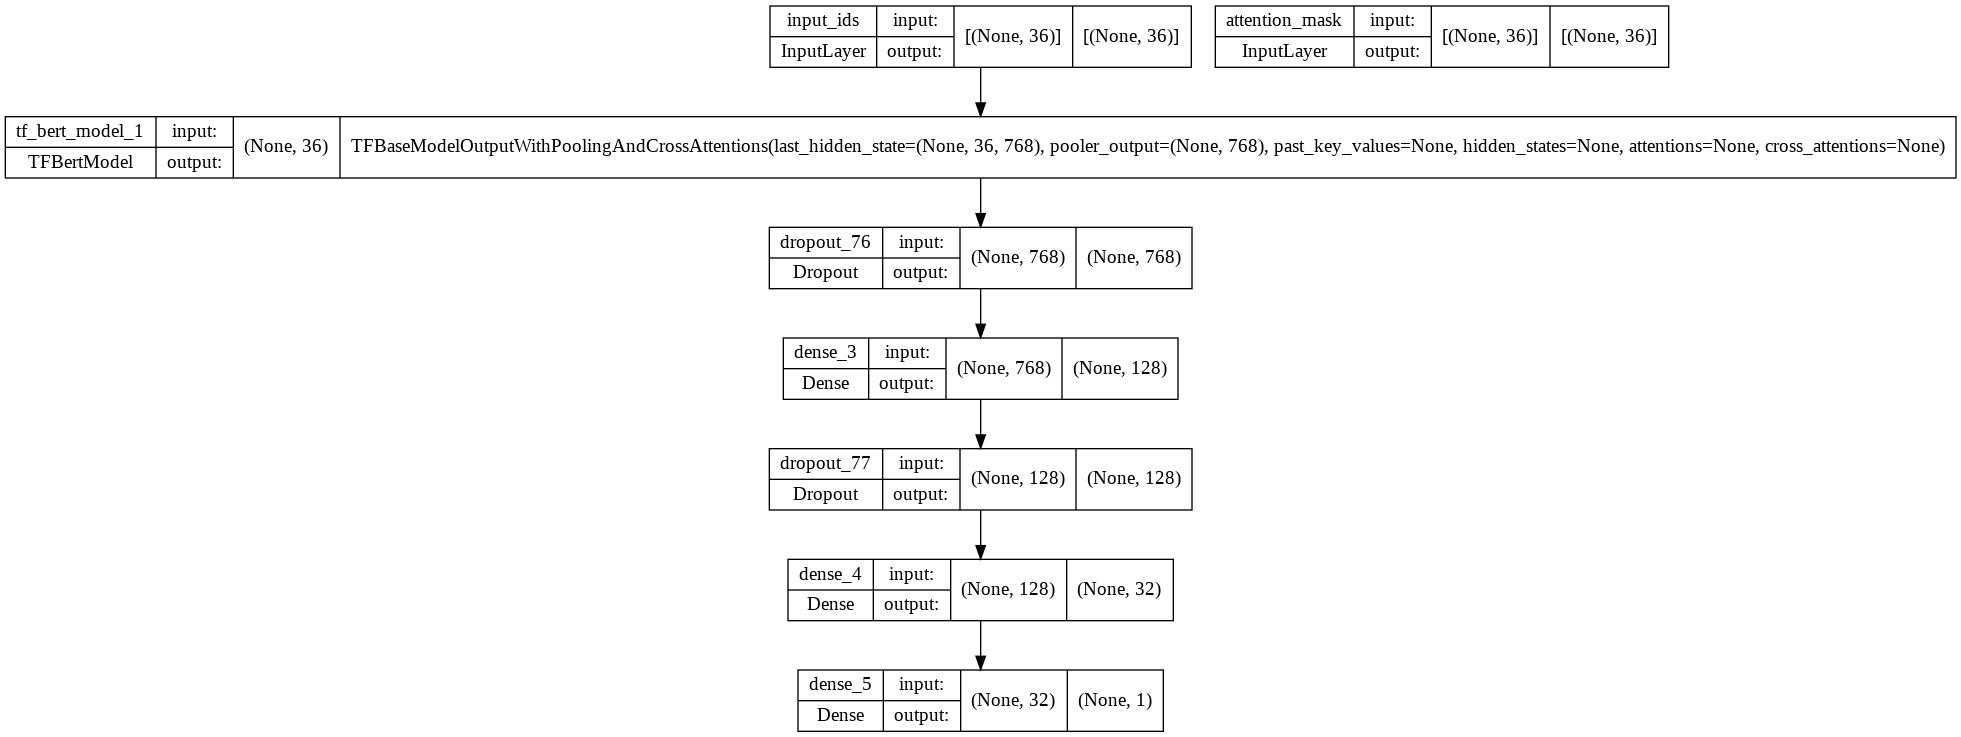

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=1,
    batch_size=10
)

500/500 [==============================] - 2303s 5s/step - loss: -1.8213 - accuracy: 0.2086


## VISUALIZATION OF LOSS AND ACCURACY CURVE:

In [ ]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']
    epochs_plot = np.arange(1, len(loss) + 1)
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

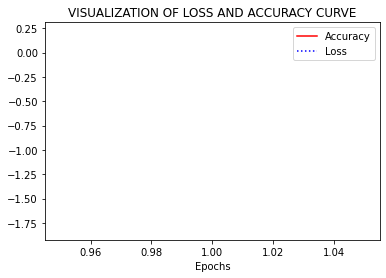

In [ ]:
visual_accuracy_and_loss(final)

Text(0.5, 1.0, 'Accuracy Curve')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Loss Curve')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

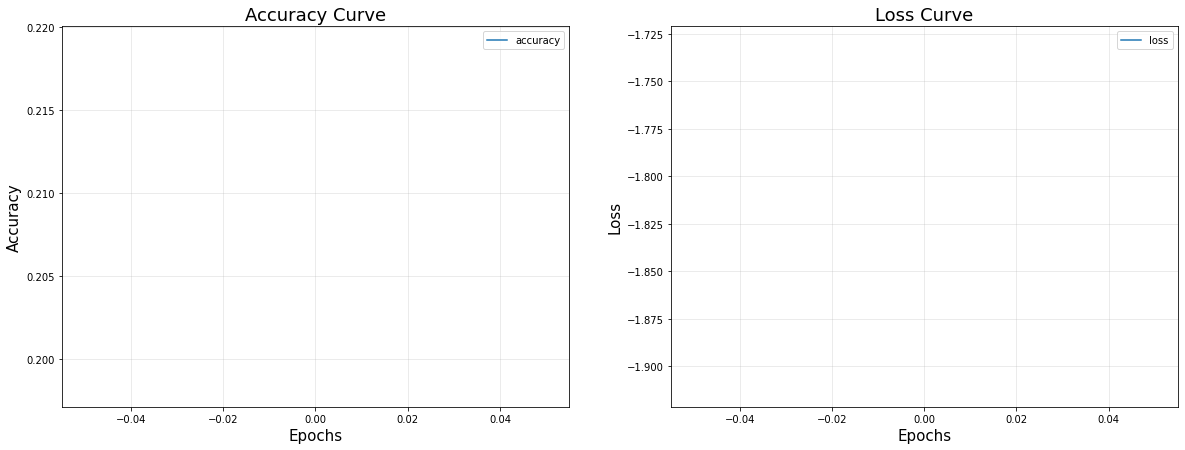

In [ ]:
# Plot the loss and accuracy curves  

#Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(final.epoch,final.history['accuracy'],label = "accuracy") # Accuracy curve 


plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(final.epoch,final.history['loss'],label="loss") # Loss curve 


plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
x_test = tokenizer(
    text=test_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

## PREDICTION:

In [ ]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [ ]:
y_predicted = np.where(predicted>0.5,1,0)

In [ ]:
m = tf.keras.metrics.Accuracy()
m.update_state(test_data.target.values, np.round(predicted,0))
print('Final result: ', m.result().numpy())  

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2999.0>

Final result:  0.15338446


## Accuracy of the model is - 15.33%